# Stock Volatility Trading Strategy : Machine Learning + GARCH Models

Enter a stock ticker [AAPL, TSLA, GOOG, etc.]:  msft



Abs. Volatility Results for MSFT :
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
MAE: 0.00121
R²: 0.92457

(Δ)Change in Volatility Model (5-Day)
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
MAE: 0.09634
R²: 0.55239

GARCH MAE: 0.00276
GARCH R²: 0.68071


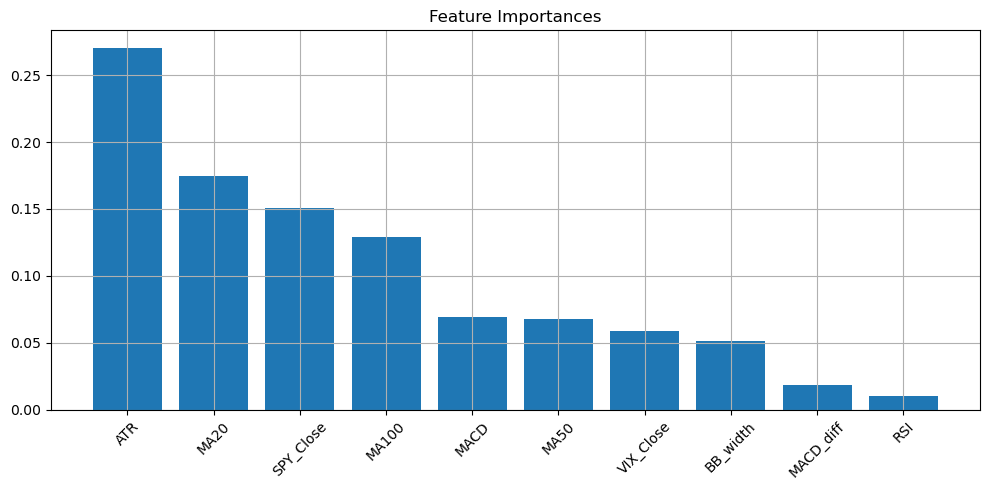

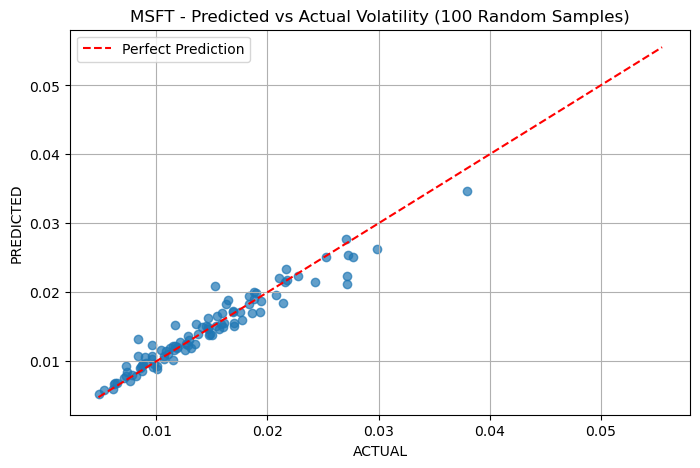

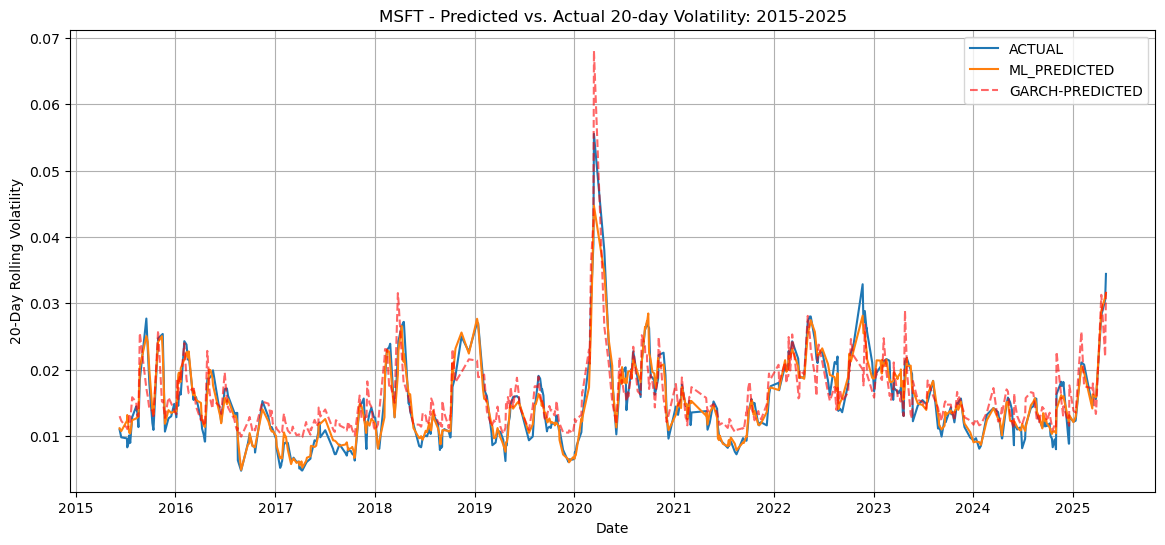

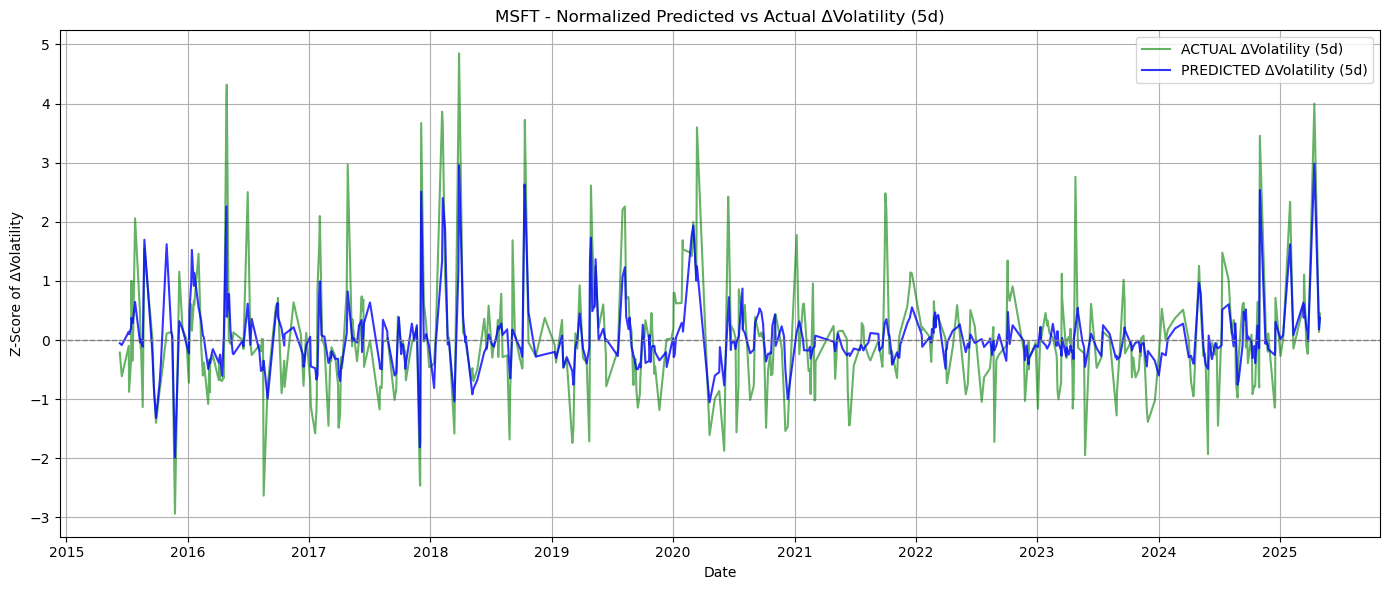


Predicted (Δ)Change in Volatility for Next Day: 0.1147100031375885
Predicted 20-Day Volatility for NEXT Trading Day: 0.03195999935269356
GARCH Forecasted Next-Day Volatility: 0.03012
Last Known Closing Price: $435.28

Estimated Price Range for Tomorrow:
Upper Bound: $449.19
Lower Bound: $421.37

🔍 Best Strategy Parameters Based on Sharpe Ratio:
ΔVol Threshold: 0.005
GARCH Threshold: 0.001


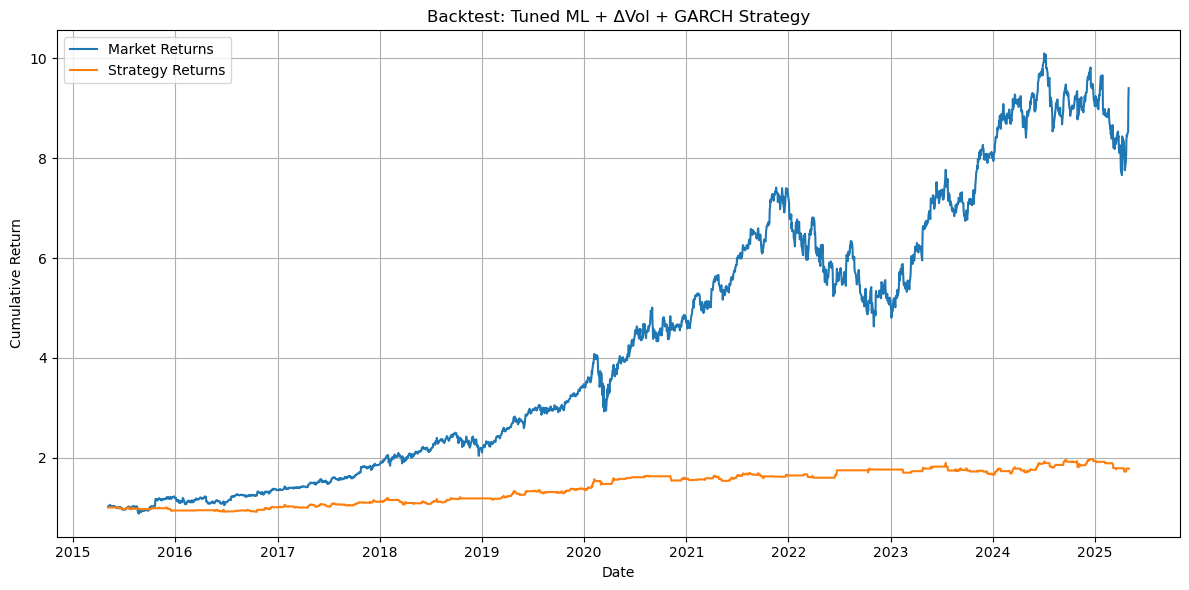


 Final Strategy Performance Metrics:
Total Return: 77.89%
Annualized Return: 5.94%
Volatility: 10.51%
Sharpe Ratio: 56.53%
Max Drawdown: 12.65%
Win Rate: 15.47%
Delta Threshold: 0.50%
GARCH Threshold: 0.10%


In [388]:
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from tiingo import TiingoClient
from alpha_vantage.timeseries import TimeSeries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from arch import arch_model
from itertools import product

config = {
    'session': True,
    'api_key': '3d01421bfd27eb6d30e7c7df881b96ecec93c27f'
}
client = TiingoClient(config)

end_date = dt.datetime.today().date()
start_date = pd.to_datetime(end_date - dt.timedelta(days=365 * 11))

ticker = input("Enter a stock ticker [AAPL, TSLA, GOOG, etc.]: ").upper()

# TIINGO Data
def fetch_data(symbol):
    data = client.get_dataframe(
        symbol,
        startDate=start_date.strftime('%Y-%m-%d'),
        endDate=end_date.strftime('%Y-%m-%d'),
        frequency='daily'
    )
    data.rename(columns={
        'close': 'Close',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'volume': 'Volume'
    }, inplace=True)
    data.index = data.index.tz_localize(None)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]
    # Open-> Price when the market opened that day
    # High-> Highest price during the day
    # Low-> Lowest Price during the day
    # Close-> Price when the market closed
    # Volume-> How many shares were traded that day

data = fetch_data(ticker)
vix = fetch_data('VIXY')[['Close']].rename(columns={'Close': 'VIX_Close'})
spy = fetch_data('SPY')[['Close']].rename(columns={'Close': 'SPY_Close'})
# VIX = Market's expectation of future volatility over the next 30 days
# VIX ↑ → Traders expect more movement (fear, uncertainty)
# VIX ↓ → Calm markets, low expected volatility
# VIX spikes during crashes or inflation surprises
# If VIX is high, volatility for individual stocks usually increases too
# S&P500
# SPY ↑ → Market is strong → Momentum might reduce stock-specific volatility
# SPY ↓ → Market weak → Volatility might rise for individual stocks
# “Is this stock moving with the market, or independently?”
# market-driven vs. idiosyncratic volatility

data = data.merge(vix, left_index=True, right_index=True, how='left')
data = data.merge(spy, left_index=True, right_index=True, how='left')
data.ffill(inplace=True)
data.bfill(inplace=True)
data.dropna(inplace=True)

data['Returns'] = data['Close'].pct_change()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA100'] = data['Close'].rolling(window=100).mean()
data['Volatility'] = data['Returns'].rolling(window=20).std()
data['Volatility_Delta_5d'] = data['Volatility'].pct_change(periods=5)

data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'], window=14).rsi()
# Relative Strength Index
# RSI > 70 = overbought | RSI < 30 = oversold
# Overbought signals that the price has risen too far, too fast, and may be poised for a decline.
# Oversold signals that the price has fallen too far, too fast, and may be poised for a rise.
bb = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
data['BB_upper'] = bb.bollinger_hband()
data['BB_lower'] = bb.bollinger_lband()
data['BB_width'] = data['BB_upper'] - data['BB_lower']
# Bollinger Bands create upper and lower limits to show volatility, based on a 20-day moving average
# dev = 2 b/c in a normal distribution, about 95% of values fall within ±2 standard deviations from the mean
data['ATR'] = ta.volatility.AverageTrueRange(high=data['High'], low=data['Low'], close=data['Close'], window=14).average_true_range()
# ATR (Average True Range) is a measure of how much a stock moves each day, on average.(abs. value, no neg/pos)
macd = ta.trend.MACD(close=data['Close'])
data['MACD'] = macd.macd()
data['MACD_diff'] = macd.macd_diff()
data.dropna(inplace=True)
# EMA = Exponential Moving Average; A way to average past prices, but it gives more weight to recent prices.
# MACD — Moving Average Convergence Divergence = EMA12(short-term) - EMA26(long-term)
# MACD Positive → Short-term is rising faster than long-term → Bullish momentum
# MACD Negative → Short-term is falling faster than long-term → Bearish momentum
# Signal Line = EMA9(days) of MACD
# MACD_diff = MACD - Signal Line
# MACD_diff > 0 → Trend is speeding up
# MACD_diff < 0 → Trend is slowing down or reversing
## If MACD is the slope of the stock, then MACD_diff is the acceleration of the stock

# data['Volume_avg20'] = data['Volume'].rolling(window=20).mean()
# data['Volume_spike'] = (data['Volume'] > 1.5 * data['Volume_avg20']).astype(int)
# took out volume spike - too much noise 
# Volume Spike Flag - If people are rushing to buy/sell, usually volatility rises right after
# Binary column: flag 1 - If volume > 1.5 × normal | 0 if normal volume day

# data['Lagged_Returns_1d'] = data['Returns'].shift(1)
# data['Lagged_Volatility_1d'] = data['Volatility'].shift(1)
# took out lagged volatility and returns - makes model lazy, and it just copies yday
# Lagged Features - yesterday's returns and 20-day rolling volatility
# shift(1) moves the coloumnn down by 1 for yesterday's data

clean_start_date = pd.to_datetime(end_date - dt.timedelta(days=365 * 10))
data = data[data.index >= clean_start_date]

features = ['MA20', 'MA50', 'MA100', 'RSI', 'BB_width', 'ATR', 'MACD', 'MACD_diff', 'VIX_Close', 'SPY_Close']
x = data[features]
y = data['Volatility']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Compared to RandomForest, XGBoost is gradient-boosted, meaning it builds trees sequentially and corrects prior errors.
xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid={
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
grid_search.fit(x_train, y_train)
model = grid_search.best_estimator_
preds = model.predict(x_test)
# Hyperparameter Tuning with GridSearchCV
# Try multiple combinations of model settings (depth, learning rate, # of trees)
# Use 3-fold cross-validation: split training data into 3 parts, test each combo, and average performance
# Goal: Find the best combo that generalizes well (not overfit)

# ΔVolatility
delta_target = 'Volatility_Delta_5d'
y_delta = data[delta_target]
x_train_d, x_test_d, y_train_d, y_test_d = train_test_split(x, y_delta, test_size=0.2, random_state=42)
grid = GridSearchCV(
    estimator=xgb,
    param_grid={
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)
grid.fit(x_train_d, y_train_d)
model_delta = grid.best_estimator_
delta_preds = model_delta.predict(x_test_d)

returns = data['Returns'].dropna() * 100
# Fit GARCH(1,1) on full return history
# The (1,1) refers to the number of lags:
# 1 lag of squared returns (the recent shock)
# 1 lag of past variance (the previous volatility)
garch_model = arch_model(returns, vol='GARCH', p=1, q=1)
garch_result = garch_model.fit(disp='off')
# Forecast next-day volatility
# Get next-day forecast from the latest available date
latest_date = returns.index[-1]
garch_forecast = garch_result.forecast(start=latest_date)
garch_var = garch_forecast.variance.loc[latest_date]
garch_vol = np.sqrt(garch_var.values[0]) / 100

delta_models = {}
delta_preds = {}

# GARCH forecast from clean start date without reindexing
garch_forecast = garch_result.forecast(start=clean_start_date)

# Extract variance forecasts
garch_var = garch_forecast.variance

# Convert to volatility (standard deviation), drop duplicate dates
garch_vol_series = pd.Series(np.sqrt(garch_var.values.flatten()) / 100, index=garch_var.index)
garch_vol_series = garch_vol_series[~garch_vol_series.index.duplicated(keep='last')]

# Align with y_test
garch_vol_series = garch_vol_series.loc[garch_vol_series.index.intersection(y_test.index)]

print("\nAbs. Volatility Results for", ticker, ":")
print("Best Parameters:", grid_search.best_params_)
print("MAE:", round(mean_absolute_error(y_test, preds), 5))
print("R²:", round(r2_score(y_test, preds), 5))

# Ensure delta_preds is regenerated if empty
if delta_preds is None or len(delta_preds) == 0:
    delta_preds = model_delta.predict(x_test_d)

# Evaluate only once and print if valid
if len(delta_preds) == len(y_test_d) and len(y_test_d) > 0:
    print("\n(Δ)Change in Volatility Model (5-Day)")
    print("Best Parameters:", grid.best_params_)
    print("MAE:", round(mean_absolute_error(y_test_d, delta_preds), 5))
    print("R²:", round(r2_score(y_test_d, delta_preds), 5))
else:
    print("❗ Still mismatch or empty prediction for ΔVol model.")



# GARCH evaluation — align by shared index
aligned_actual = y_test.loc[y_test.index.intersection(garch_vol_series.index)]
aligned_garch = garch_vol_series.loc[aligned_actual.index]

print("\nGARCH MAE:", round(mean_absolute_error(aligned_actual, aligned_garch), 5))
print("GARCH R²:", round(r2_score(aligned_actual, aligned_garch), 5))


importances = model.feature_importances_
ordered = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[ordered], align='center')
plt.xticks(range(len(importances)), [features[i] for i in ordered], rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_test.values[:100], preds[:100], alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("ACTUAL")
plt.ylabel("PREDICTED")
plt.title(ticker + " - Predicted vs Actual Volatility (100 Random Samples)")
plt.legend()
plt.grid(True)
plt.show()

sorted_dates = y_test.sort_index().index
y_test_sorted = y_test.loc[sorted_dates]
preds_sorted = pd.Series(preds, index=x_test.index).loc[sorted_dates]
plt.figure(figsize=(14, 6))
plt.plot(y_test_sorted.index, y_test_sorted.values, label='ACTUAL')
plt.plot(y_test_sorted.index, preds_sorted.values, label='ML_PREDICTED')
# Drop duplicates in garch_vol_series (optional: some dates repeat if reindex=True earlier)
garch_vol_series_clean = garch_vol_series[~garch_vol_series.index.duplicated(keep='last')]
# Then plot:
plt.plot(garch_vol_series_clean.index, garch_vol_series_clean.values, label='GARCH-PREDICTED', color='red', alpha=0.6, linestyle='--')

plt.legend()
plt.title(ticker + " - Predicted vs. Actual 20-day Volatility: 2015-2025")
plt.xlabel("Date")
plt.ylabel("20-Day Rolling Volatility")
plt.grid(True)
plt.show()

# Recreate delta_preds if needed
if delta_preds is None or len(delta_preds) == 0:
    delta_preds = model_delta.predict(x_test_d)

# Align predictions and actuals
delta_preds_series = pd.Series(delta_preds, index=x_test_d.index).sort_index()
y_test_5d = y_test_d.sort_index()

# Combine and drop missing
combined = pd.DataFrame({
    'Actual': y_test_5d,
    'Predicted': delta_preds_series
}).dropna()

# Normalize
actual_norm = (combined['Actual'] - combined['Actual'].mean()) / combined['Actual'].std()
preds_norm = (combined['Predicted'] - combined['Actual'].mean()) / combined['Actual'].std()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(combined.index, actual_norm, label='ACTUAL ΔVolatility (5d)', color='green', alpha=0.6)
plt.plot(combined.index, preds_norm, label='PREDICTED ΔVolatility (5d)', color='blue', alpha=0.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f"{ticker} - Normalized Predicted vs Actual ΔVolatility (5d)")
plt.xlabel("Date")
plt.ylabel("Z-Score of ΔVolatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# === Prediction for Next Day ===
latest_values = [data[feature].iloc[-1] for feature in features]
latest_features = pd.DataFrame([latest_values], columns=features)

next_day_volatility = model.predict(latest_features)[0]
delta_volatility = model_delta.predict(latest_features)[0]
last_close = float(data['Close'].iloc[-1])

print(f"\nPredicted (Δ)Change in Volatility for Next Day: {round(delta_volatility, 5)}")
print(f"Predicted 20-Day Volatility for NEXT Trading Day: {round(next_day_volatility, 5)}")
print(f"GARCH Forecasted Next-Day Volatility: {round(garch_vol, 5)}")
print(f"Last Known Closing Price: ${round(last_close, 2)}")

upper_bound = last_close * (1 + next_day_volatility)
lower_bound = last_close * (1 - next_day_volatility)
print("\nEstimated Price Range for Tomorrow:")
print(f"Upper Bound: ${round(upper_bound, 2)}")
print(f"Lower Bound: ${round(lower_bound, 2)}")

# === Performance Metrics Calculation ===
def calculate_metrics(returns):
    returns = returns.dropna()
    if len(returns) < 2:
        return {
            'Total Return': 0,
            'Annualized Return': 0,
            'Volatility': 0,
            'Sharpe Ratio': 0,
            'Max Drawdown': 0,
            'Win Rate': 0
        }

    cumulative = (1 + returns).cumprod()
    total_return = cumulative.iloc[-1] - 1
    # FIXED: Use actual trading days for annualization
    n_days = len(returns)
    annualized_return = (1 + total_return) ** (252 / n_days) - 1

    # FIXED: daily stddev used for annualized volatility
    volatility = returns.std(ddof=0) * np.sqrt(252)

    # FIXED: realistic Sharpe
    # Cap to avoid distorted values from low-vol periods
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0

    # Drawdown
    max_drawdown = 1 - cumulative.div(cumulative.cummax()).min()
    win_rate = (returns > 0).mean()

    return {
    'Total Return': total_return,
    'Annualized Return': annualized_return,
    'Volatility': volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Win Rate': win_rate
    }




# === Simulate Volatility-Driven Strategy with Momentum Confirmation ===
def simulate_strategy(delta_threshold, garch_threshold):
    prediction_data = data.dropna(subset=features).copy()
    ml_vol_preds = model.predict(prediction_data[features])
    delta_vol_preds = model_delta.predict(prediction_data[features])
    garch_vol_preds = garch_vol_series.reindex(prediction_data.index).ffill()

    # Percent momentum (price change over 3 days)
    prediction_data['Momentum'] = prediction_data['Close'].pct_change(periods=3)

    signals = []
    for i in range(len(prediction_data)):
        if i < 3:
            signals.append("HOLD")
            continue

        delta_pred = delta_vol_preds[i]
        garch_val = garch_vol_preds.iloc[i]
        ml_val = ml_vol_preds[i]
        momentum = prediction_data['Momentum'].iloc[i]

        # FIXED: React to strong volatility changes in any direction
        if abs(delta_pred) > delta_threshold and (garch_val - ml_val) > garch_threshold and momentum > 0:
            signals.append("BUY")
        else:
            signals.append("HOLD")

    prediction_data['Signal'] = signals
    prediction_data['Next_Close'] = prediction_data['Close'].shift(-1)
    prediction_data['Return'] = prediction_data['Next_Close'] / prediction_data['Close'] - 1
    prediction_data['Strategy_Return'] = prediction_data.apply(
        lambda row: row['Return'] if row['Signal'] == 'BUY' else 0, axis=1
    )
    prediction_data['Cumulative_Market'] = (1 + prediction_data['Return']).cumprod()
    prediction_data['Cumulative_Strategy'] = (1 + prediction_data['Strategy_Return']).cumprod()

    metrics = calculate_metrics(prediction_data['Strategy_Return'])
    metrics.update({
        'Delta Threshold': delta_threshold,
        'GARCH Threshold': garch_threshold
    })
    return metrics, prediction_data


# === Grid Search for Best Parameters ===
delta_thresholds = [0.005, 0.007, 0.01]
garch_thresholds = [0.001, 0.0015, 0.002]

results = []
for delta_thresh, garch_thresh in product(delta_thresholds, garch_thresholds):
    metrics, _ = simulate_strategy(delta_thresh, garch_thresh)
    results.append(metrics)

results_df = pd.DataFrame(results).sort_values(by='Sharpe Ratio', ascending=False)
best_params = results_df.iloc[0]
best_delta = best_params['Delta Threshold']
best_garch = best_params['GARCH Threshold']

print("\n🔍 Best Strategy Parameters Based on Sharpe Ratio:")
print(f"ΔVol Threshold: {best_delta}")
print(f"GARCH Threshold: {best_garch}")

# === Final Simulation ===
final_metrics, final_data = simulate_strategy(best_delta, best_garch)

# === Plotting Strategy vs Market ===
plt.figure(figsize=(12, 6))
plt.plot(final_data.index, final_data['Cumulative_Market'], label='Market Returns')
plt.plot(final_data.index, final_data['Cumulative_Strategy'], label='Strategy Returns')
plt.title("Backtest: Tuned ML + ΔVol + GARCH Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print Final Metrics ===
print("\n Final Strategy Performance Metrics:")
for k, v in final_metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.2%}")
    else:
        print(f"{k}: {v}")

